In [1]:
#IMPORTS

#File IO
import os
import glob

#Data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn.functional as F
from segmentation_models_pytorch import Unet

#Scikit learn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score

#Misc
from tqdm import tqdm


In [2]:
#HYPERPARMETERS

train_proportion = .8
val_proportion = .1

batch_size = 128
learning_rate = .00002
num_epochs = 100

In [3]:
#CREATE DATASET

dataset = torch.load("cps_unet_dataset.pt", weights_only=False)

In [4]:
#CREATE DATALOADERS

train_size = int(train_proportion * len(dataset))
val_size = int(val_proportion * len(dataset))
test_size = len(dataset) - train_size - val_size

generator = torch.Generator().manual_seed(1)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=generator)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
#CREATE MODEL

model = Unet(
    encoder_name="resnet34",
    in_channels=16,
    classes=1,
    activation=None
)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [6]:
#TRAIN and EVALUATE FUNCTIONS

def train(model, train_loader):
    model.train()
    train_loss = 0
    all_preds = []
    all_labels = []

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.squeeze(2)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        all_preds.append(outputs.detach().cpu().numpy())
        all_labels.append(labels.cpu().numpy())

    avg_loss = train_loss / len(train_loader)

    y_true = np.concatenate(all_labels).ravel()
    y_pred = np.concatenate(all_preds).ravel()
    r2 = r2_score(y_true, y_pred)

    return avg_loss, r2


def eval(model, val_loader):
    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.squeeze(2)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            all_preds.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    avg_loss = val_loss / len(val_loader)
    y_true = np.concatenate(all_labels).ravel()
    y_pred = np.concatenate(all_preds).ravel()
    r2 = r2_score(y_true, y_pred)

    return avg_loss, r2


In [7]:
#TRAIN MODEL

for e in range(1, num_epochs+1):
    train_loss, train_acc = train(model, train_loader)
    val_loss, val_acc = eval(model, val_loader)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch: {e} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

100%|██████████| 94/94 [00:12<00:00,  7.30it/s]


Epoch: 1 | Train Loss: 9.5006 | Train Acc: -3.0698 | Val Loss: 8.6038 | Val Acc: -2.7379


100%|██████████| 94/94 [00:10<00:00,  9.02it/s]


Epoch: 2 | Train Loss: 7.0641 | Train Acc: -2.0258 | Val Loss: 6.4610 | Val Acc: -1.8061


100%|██████████| 94/94 [00:10<00:00,  8.59it/s]


Epoch: 3 | Train Loss: 6.0568 | Train Acc: -1.5943 | Val Loss: 5.7413 | Val Acc: -1.4955


100%|██████████| 94/94 [00:11<00:00,  7.87it/s]


Epoch: 4 | Train Loss: 5.3415 | Train Acc: -1.2874 | Val Loss: 5.8990 | Val Acc: -1.5685


100%|██████████| 94/94 [00:11<00:00,  8.14it/s]


Epoch: 5 | Train Loss: 4.7677 | Train Acc: -1.0404 | Val Loss: 5.7569 | Val Acc: -1.5085


100%|██████████| 94/94 [00:10<00:00,  8.81it/s]


Epoch: 6 | Train Loss: 4.3057 | Train Acc: -0.8446 | Val Loss: 4.5681 | Val Acc: -0.9870


100%|██████████| 94/94 [00:10<00:00,  9.01it/s]


Epoch: 7 | Train Loss: 3.9414 | Train Acc: -0.6871 | Val Loss: 3.9036 | Val Acc: -0.6953


100%|██████████| 94/94 [00:10<00:00,  8.93it/s]


Epoch: 8 | Train Loss: 3.5738 | Train Acc: -0.5307 | Val Loss: 3.2412 | Val Acc: -0.4083


100%|██████████| 94/94 [00:10<00:00,  8.91it/s]


Epoch: 9 | Train Loss: 3.2510 | Train Acc: -0.3913 | Val Loss: 3.2630 | Val Acc: -0.4196


100%|██████████| 94/94 [00:10<00:00,  8.89it/s]


Epoch: 10 | Train Loss: 2.9561 | Train Acc: -0.2664 | Val Loss: 3.4642 | Val Acc: -0.5075


100%|██████████| 94/94 [00:10<00:00,  8.61it/s]


Epoch: 11 | Train Loss: 2.7035 | Train Acc: -0.1574 | Val Loss: 2.4788 | Val Acc: -0.0768


100%|██████████| 94/94 [00:10<00:00,  8.90it/s]


Epoch: 12 | Train Loss: 2.4610 | Train Acc: -0.0549 | Val Loss: 2.4179 | Val Acc: -0.0521


100%|██████████| 94/94 [00:10<00:00,  9.03it/s]


Epoch: 13 | Train Loss: 2.2581 | Train Acc: 0.0330 | Val Loss: 2.1308 | Val Acc: 0.0731


100%|██████████| 94/94 [00:10<00:00,  8.87it/s]


Epoch: 14 | Train Loss: 2.0732 | Train Acc: 0.1125 | Val Loss: 1.8760 | Val Acc: 0.1848


100%|██████████| 94/94 [00:10<00:00,  8.96it/s]


Epoch: 15 | Train Loss: 1.9047 | Train Acc: 0.1849 | Val Loss: 2.2879 | Val Acc: 0.0024


100%|██████████| 94/94 [00:10<00:00,  8.87it/s]


Epoch: 16 | Train Loss: 1.7456 | Train Acc: 0.2520 | Val Loss: 1.7365 | Val Acc: 0.2449


100%|██████████| 94/94 [00:10<00:00,  8.99it/s]


Epoch: 17 | Train Loss: 1.6036 | Train Acc: 0.3131 | Val Loss: 1.6504 | Val Acc: 0.2820


100%|██████████| 94/94 [00:10<00:00,  8.87it/s]


Epoch: 18 | Train Loss: 1.4818 | Train Acc: 0.3658 | Val Loss: 1.5782 | Val Acc: 0.3137


100%|██████████| 94/94 [00:10<00:00,  9.07it/s]


Epoch: 19 | Train Loss: 1.3629 | Train Acc: 0.4161 | Val Loss: 1.4832 | Val Acc: 0.3546


100%|██████████| 94/94 [00:10<00:00,  9.02it/s]


Epoch: 20 | Train Loss: 1.2607 | Train Acc: 0.4608 | Val Loss: 1.7061 | Val Acc: 0.2549


100%|██████████| 94/94 [00:10<00:00,  8.96it/s]


Epoch: 21 | Train Loss: 1.1635 | Train Acc: 0.5017 | Val Loss: 1.1935 | Val Acc: 0.4806


100%|██████████| 94/94 [00:10<00:00,  8.87it/s]


Epoch: 22 | Train Loss: 1.0789 | Train Acc: 0.5381 | Val Loss: 2.0434 | Val Acc: 0.1017


100%|██████████| 94/94 [00:10<00:00,  8.72it/s]


Epoch: 23 | Train Loss: 1.0026 | Train Acc: 0.5705 | Val Loss: 1.2328 | Val Acc: 0.4623


100%|██████████| 94/94 [00:10<00:00,  8.90it/s]


Epoch: 24 | Train Loss: 0.9364 | Train Acc: 0.5990 | Val Loss: 1.1754 | Val Acc: 0.4870


100%|██████████| 94/94 [00:10<00:00,  8.98it/s]


Epoch: 25 | Train Loss: 0.8748 | Train Acc: 0.6253 | Val Loss: 0.9945 | Val Acc: 0.5670


100%|██████████| 94/94 [00:10<00:00,  8.99it/s]


Epoch: 26 | Train Loss: 0.8257 | Train Acc: 0.6465 | Val Loss: 0.9906 | Val Acc: 0.5685


100%|██████████| 94/94 [00:10<00:00,  8.97it/s]


Epoch: 27 | Train Loss: 0.7860 | Train Acc: 0.6635 | Val Loss: 1.5948 | Val Acc: 0.2991


100%|██████████| 94/94 [00:10<00:00,  9.00it/s]


Epoch: 28 | Train Loss: 0.7560 | Train Acc: 0.6762 | Val Loss: 0.9602 | Val Acc: 0.5818


100%|██████████| 94/94 [00:10<00:00,  8.98it/s]


Epoch: 29 | Train Loss: 0.7259 | Train Acc: 0.6892 | Val Loss: 0.8113 | Val Acc: 0.6476


100%|██████████| 94/94 [00:10<00:00,  8.96it/s]


Epoch: 30 | Train Loss: 0.7104 | Train Acc: 0.6960 | Val Loss: 1.0428 | Val Acc: 0.5442


100%|██████████| 94/94 [00:10<00:00,  8.98it/s]


Epoch: 31 | Train Loss: 0.6811 | Train Acc: 0.7085 | Val Loss: 3.7737 | Val Acc: -0.6731


100%|██████████| 94/94 [00:10<00:00,  8.99it/s]


Epoch: 32 | Train Loss: 0.6642 | Train Acc: 0.7156 | Val Loss: 0.9176 | Val Acc: 0.6000


100%|██████████| 94/94 [00:10<00:00,  8.73it/s]


Epoch: 33 | Train Loss: 0.6472 | Train Acc: 0.7229 | Val Loss: 0.7905 | Val Acc: 0.6562


100%|██████████| 94/94 [00:11<00:00,  8.52it/s]


Epoch: 34 | Train Loss: 0.6403 | Train Acc: 0.7259 | Val Loss: 0.9084 | Val Acc: 0.6034


100%|██████████| 94/94 [00:10<00:00,  9.00it/s]


Epoch: 35 | Train Loss: 0.6302 | Train Acc: 0.7303 | Val Loss: 0.7999 | Val Acc: 0.6518


100%|██████████| 94/94 [00:10<00:00,  9.04it/s]


Epoch: 36 | Train Loss: 0.6235 | Train Acc: 0.7329 | Val Loss: 0.8131 | Val Acc: 0.6459


100%|██████████| 94/94 [00:10<00:00,  9.05it/s]


Epoch: 37 | Train Loss: 0.6128 | Train Acc: 0.7376 | Val Loss: 0.7357 | Val Acc: 0.6805


100%|██████████| 94/94 [00:10<00:00,  8.95it/s]


Epoch: 38 | Train Loss: 0.6058 | Train Acc: 0.7406 | Val Loss: 0.7210 | Val Acc: 0.6876


100%|██████████| 94/94 [00:10<00:00,  9.03it/s]


Epoch: 39 | Train Loss: 0.6040 | Train Acc: 0.7412 | Val Loss: 0.7085 | Val Acc: 0.6925


100%|██████████| 94/94 [00:10<00:00,  8.97it/s]


Epoch: 40 | Train Loss: 0.5934 | Train Acc: 0.7460 | Val Loss: 0.7611 | Val Acc: 0.6689


100%|██████████| 94/94 [00:10<00:00,  8.96it/s]


Epoch: 41 | Train Loss: 0.5929 | Train Acc: 0.7462 | Val Loss: 0.7775 | Val Acc: 0.6618


100%|██████████| 94/94 [00:10<00:00,  8.97it/s]


Epoch: 42 | Train Loss: 0.5926 | Train Acc: 0.7463 | Val Loss: 0.7262 | Val Acc: 0.6848


100%|██████████| 94/94 [00:10<00:00,  8.94it/s]


Epoch: 43 | Train Loss: 0.5874 | Train Acc: 0.7486 | Val Loss: 0.6991 | Val Acc: 0.6970


100%|██████████| 94/94 [00:12<00:00,  7.39it/s]


Epoch: 44 | Train Loss: 0.5822 | Train Acc: 0.7508 | Val Loss: 0.7235 | Val Acc: 0.6858


100%|██████████| 94/94 [00:11<00:00,  8.49it/s]


Epoch: 45 | Train Loss: 0.5791 | Train Acc: 0.7519 | Val Loss: 0.7059 | Val Acc: 0.6939


100%|██████████| 94/94 [00:11<00:00,  8.48it/s]


Epoch: 46 | Train Loss: 0.5720 | Train Acc: 0.7550 | Val Loss: 0.7420 | Val Acc: 0.6782


100%|██████████| 94/94 [00:10<00:00,  8.96it/s]


Epoch: 47 | Train Loss: 0.5705 | Train Acc: 0.7556 | Val Loss: 0.7443 | Val Acc: 0.6762


100%|██████████| 94/94 [00:10<00:00,  8.86it/s]


Epoch: 48 | Train Loss: 0.5628 | Train Acc: 0.7592 | Val Loss: 0.7085 | Val Acc: 0.6920


100%|██████████| 94/94 [00:10<00:00,  8.96it/s]


Epoch: 49 | Train Loss: 0.5585 | Train Acc: 0.7610 | Val Loss: 0.6699 | Val Acc: 0.7095


100%|██████████| 94/94 [00:10<00:00,  8.91it/s]


Epoch: 50 | Train Loss: 0.5622 | Train Acc: 0.7595 | Val Loss: 0.6662 | Val Acc: 0.7113


100%|██████████| 94/94 [00:10<00:00,  8.96it/s]


Epoch: 51 | Train Loss: 0.5534 | Train Acc: 0.7629 | Val Loss: 0.6753 | Val Acc: 0.7071


100%|██████████| 94/94 [00:10<00:00,  8.97it/s]


Epoch: 52 | Train Loss: 0.5601 | Train Acc: 0.7602 | Val Loss: 0.6711 | Val Acc: 0.7088


100%|██████████| 94/94 [00:10<00:00,  8.94it/s]


Epoch: 53 | Train Loss: 0.5509 | Train Acc: 0.7642 | Val Loss: 0.6800 | Val Acc: 0.7053


100%|██████████| 94/94 [00:10<00:00,  8.90it/s]


Epoch: 54 | Train Loss: 0.5453 | Train Acc: 0.7664 | Val Loss: 0.6507 | Val Acc: 0.7179


100%|██████████| 94/94 [00:10<00:00,  8.94it/s]


Epoch: 55 | Train Loss: 0.5449 | Train Acc: 0.7668 | Val Loss: 0.6983 | Val Acc: 0.6972


100%|██████████| 94/94 [00:10<00:00,  8.96it/s]


Epoch: 56 | Train Loss: 0.5377 | Train Acc: 0.7697 | Val Loss: 0.6774 | Val Acc: 0.7061


100%|██████████| 94/94 [00:10<00:00,  8.75it/s]


Epoch: 57 | Train Loss: 0.5580 | Train Acc: 0.7611 | Val Loss: 0.6732 | Val Acc: 0.7081


100%|██████████| 94/94 [00:11<00:00,  8.18it/s]


Epoch: 58 | Train Loss: 0.5373 | Train Acc: 0.7699 | Val Loss: 0.6653 | Val Acc: 0.7113


100%|██████████| 94/94 [00:10<00:00,  8.59it/s]


Epoch: 59 | Train Loss: 0.5350 | Train Acc: 0.7709 | Val Loss: 0.6812 | Val Acc: 0.7049


100%|██████████| 94/94 [00:10<00:00,  8.83it/s]


Epoch: 60 | Train Loss: 0.5308 | Train Acc: 0.7729 | Val Loss: 0.6626 | Val Acc: 0.7128


100%|██████████| 94/94 [00:10<00:00,  8.82it/s]


Epoch: 61 | Train Loss: 0.5264 | Train Acc: 0.7747 | Val Loss: 0.6475 | Val Acc: 0.7195


100%|██████████| 94/94 [00:10<00:00,  8.63it/s]


Epoch: 62 | Train Loss: 0.5219 | Train Acc: 0.7764 | Val Loss: 0.6389 | Val Acc: 0.7231


100%|██████████| 94/94 [00:10<00:00,  8.81it/s]


Epoch: 63 | Train Loss: 0.5229 | Train Acc: 0.7761 | Val Loss: 0.7054 | Val Acc: 0.6945


100%|██████████| 94/94 [00:10<00:00,  8.86it/s]


Epoch: 64 | Train Loss: 0.5178 | Train Acc: 0.7783 | Val Loss: 0.6834 | Val Acc: 0.7038


100%|██████████| 94/94 [00:10<00:00,  8.87it/s]


Epoch: 65 | Train Loss: 0.5195 | Train Acc: 0.7775 | Val Loss: 0.6485 | Val Acc: 0.7190


100%|██████████| 94/94 [00:10<00:00,  8.93it/s]


Epoch: 66 | Train Loss: 0.5204 | Train Acc: 0.7772 | Val Loss: 0.6828 | Val Acc: 0.7033


100%|██████████| 94/94 [00:10<00:00,  8.88it/s]


Epoch: 67 | Train Loss: 0.5098 | Train Acc: 0.7817 | Val Loss: 0.6529 | Val Acc: 0.7166


100%|██████████| 94/94 [00:10<00:00,  8.98it/s]


Epoch: 68 | Train Loss: 0.5076 | Train Acc: 0.7827 | Val Loss: 0.6421 | Val Acc: 0.7218


100%|██████████| 94/94 [00:11<00:00,  8.38it/s]


Epoch: 69 | Train Loss: 0.5037 | Train Acc: 0.7843 | Val Loss: 0.6360 | Val Acc: 0.7242


100%|██████████| 94/94 [00:11<00:00,  8.24it/s]


Epoch: 70 | Train Loss: 0.5031 | Train Acc: 0.7845 | Val Loss: 0.6302 | Val Acc: 0.7268


100%|██████████| 94/94 [00:11<00:00,  8.35it/s]


Epoch: 71 | Train Loss: 0.5006 | Train Acc: 0.7857 | Val Loss: 0.6338 | Val Acc: 0.7252


100%|██████████| 94/94 [00:10<00:00,  8.80it/s]


Epoch: 72 | Train Loss: 0.4964 | Train Acc: 0.7875 | Val Loss: 0.6256 | Val Acc: 0.7288


100%|██████████| 94/94 [00:10<00:00,  8.89it/s]


Epoch: 73 | Train Loss: 0.4972 | Train Acc: 0.7871 | Val Loss: 0.6557 | Val Acc: 0.7153


100%|██████████| 94/94 [00:10<00:00,  8.92it/s]


Epoch: 74 | Train Loss: 0.4967 | Train Acc: 0.7873 | Val Loss: 0.6441 | Val Acc: 0.7207


100%|██████████| 94/94 [00:10<00:00,  8.92it/s]


Epoch: 75 | Train Loss: 0.4920 | Train Acc: 0.7894 | Val Loss: 0.6291 | Val Acc: 0.7271


100%|██████████| 94/94 [00:10<00:00,  8.91it/s]


Epoch: 76 | Train Loss: 0.4871 | Train Acc: 0.7914 | Val Loss: 0.6229 | Val Acc: 0.7299


100%|██████████| 94/94 [00:10<00:00,  8.87it/s]


Epoch: 77 | Train Loss: 0.4866 | Train Acc: 0.7916 | Val Loss: 0.6433 | Val Acc: 0.7211


100%|██████████| 94/94 [00:10<00:00,  8.94it/s]


Epoch: 78 | Train Loss: 0.4871 | Train Acc: 0.7914 | Val Loss: 0.6164 | Val Acc: 0.7328


100%|██████████| 94/94 [00:10<00:00,  8.97it/s]


Epoch: 79 | Train Loss: 0.4841 | Train Acc: 0.7928 | Val Loss: 0.6168 | Val Acc: 0.7326


100%|██████████| 94/94 [00:10<00:00,  8.91it/s]


Epoch: 80 | Train Loss: 0.4814 | Train Acc: 0.7938 | Val Loss: 0.6150 | Val Acc: 0.7333


100%|██████████| 94/94 [00:10<00:00,  8.90it/s]


Epoch: 81 | Train Loss: 0.4789 | Train Acc: 0.7951 | Val Loss: 0.6290 | Val Acc: 0.7272


100%|██████████| 94/94 [00:10<00:00,  8.68it/s]


Epoch: 82 | Train Loss: 0.4760 | Train Acc: 0.7962 | Val Loss: 0.6315 | Val Acc: 0.7261


100%|██████████| 94/94 [00:10<00:00,  8.65it/s]


Epoch: 83 | Train Loss: 0.4725 | Train Acc: 0.7978 | Val Loss: 0.6414 | Val Acc: 0.7222


100%|██████████| 94/94 [00:10<00:00,  8.89it/s]


Epoch: 84 | Train Loss: 0.4741 | Train Acc: 0.7970 | Val Loss: 0.6224 | Val Acc: 0.7302


100%|██████████| 94/94 [00:10<00:00,  8.96it/s]


Epoch: 85 | Train Loss: 0.4732 | Train Acc: 0.7975 | Val Loss: 0.6397 | Val Acc: 0.7230


100%|██████████| 94/94 [00:10<00:00,  8.80it/s]


Epoch: 86 | Train Loss: 0.4737 | Train Acc: 0.7975 | Val Loss: 0.7100 | Val Acc: 0.6915


100%|██████████| 94/94 [00:11<00:00,  8.44it/s]


Epoch: 87 | Train Loss: 0.4815 | Train Acc: 0.7940 | Val Loss: 0.6315 | Val Acc: 0.7262


100%|██████████| 94/94 [00:10<00:00,  8.56it/s]


Epoch: 88 | Train Loss: 0.4682 | Train Acc: 0.7997 | Val Loss: 0.6214 | Val Acc: 0.7305


100%|██████████| 94/94 [00:10<00:00,  8.64it/s]


Epoch: 89 | Train Loss: 0.4664 | Train Acc: 0.8003 | Val Loss: 0.6249 | Val Acc: 0.7293


100%|██████████| 94/94 [00:10<00:00,  8.65it/s]


Epoch: 90 | Train Loss: 0.4647 | Train Acc: 0.8009 | Val Loss: 0.6222 | Val Acc: 0.7302


100%|██████████| 94/94 [00:10<00:00,  8.83it/s]


Epoch: 91 | Train Loss: 0.4604 | Train Acc: 0.8029 | Val Loss: 0.6141 | Val Acc: 0.7342


100%|██████████| 94/94 [00:10<00:00,  9.04it/s]


Epoch: 92 | Train Loss: 0.4598 | Train Acc: 0.8031 | Val Loss: 0.6045 | Val Acc: 0.7380


100%|██████████| 94/94 [00:10<00:00,  8.84it/s]


Epoch: 93 | Train Loss: 0.4605 | Train Acc: 0.8030 | Val Loss: 0.6242 | Val Acc: 0.7291


100%|██████████| 94/94 [00:11<00:00,  8.41it/s]


Epoch: 94 | Train Loss: 0.4569 | Train Acc: 0.8044 | Val Loss: 0.6138 | Val Acc: 0.7338


100%|██████████| 94/94 [00:11<00:00,  8.07it/s]


Epoch: 95 | Train Loss: 0.4565 | Train Acc: 0.8045 | Val Loss: 0.6059 | Val Acc: 0.7373


100%|██████████| 94/94 [00:11<00:00,  8.28it/s]


Epoch: 96 | Train Loss: 0.4537 | Train Acc: 0.8057 | Val Loss: 0.6002 | Val Acc: 0.7396


100%|██████████| 94/94 [00:11<00:00,  8.52it/s]


Epoch: 97 | Train Loss: 0.4528 | Train Acc: 0.8062 | Val Loss: 0.6028 | Val Acc: 0.7388


100%|██████████| 94/94 [00:10<00:00,  8.79it/s]


Epoch: 98 | Train Loss: 0.4522 | Train Acc: 0.8064 | Val Loss: 0.6286 | Val Acc: 0.7278


100%|██████████| 94/94 [00:11<00:00,  8.29it/s]


Epoch: 99 | Train Loss: 0.4483 | Train Acc: 0.8080 | Val Loss: 0.5896 | Val Acc: 0.7444


100%|██████████| 94/94 [00:11<00:00,  8.48it/s]


Epoch: 100 | Train Loss: 0.4474 | Train Acc: 0.8085 | Val Loss: 0.6123 | Val Acc: 0.7349


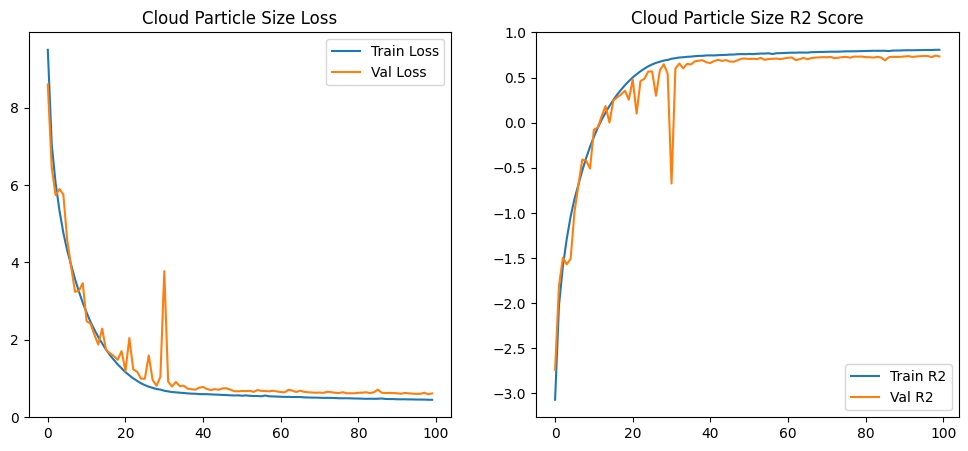

In [8]:
#PLOT LOSS and ACCURACY

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Cloud Particle Size Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train R2')
plt.plot(val_accuracies, label='Val R2')
plt.title('Cloud Particle Size R2 Score')
plt.legend()

plt.savefig("./graphs/unet_cps.png")  

plt.show()

In [9]:
#MODEL EVALUATION

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs = inputs.to(device).float()
        labels = labels.to(device)
        outputs = model(inputs)

        all_preds.append(outputs.cpu().numpy().reshape(-1))
        all_labels.append(labels.cpu().numpy().reshape(-1))

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print("r2:", r2_score(all_labels, all_preds))
print("MSE:", mean_squared_error(all_labels, all_preds))

100%|██████████| 12/12 [00:00<00:00, 15.46it/s]


r2: 0.7384099960327148
MSE: 0.6284335851669312
